# Support Intelligence & Risk Monitoring — Modeling Baselines (T4)

This notebook trains and evaluates **strong baseline models** for an operational support system:
1) **Ticket triage** into business categories: **Billing / Bug / Account / Other**  
2) **Priority prediction**: **low / medium / high**

## Context
In T3, we produced a cleaned, analytics-ready dataset with:
- a robust `message` field (handles missing subjects),
- normalized tags (`tags`, `n_tags`),
- lightweight quality features (`body_len`, `is_very_short`),
- a first taxonomy label `category_mapped` (rule-based V1).

This T4 step focuses on **modeling baselines** that are:
- fast to train and run,
- easy to interpret,
- suitable for integration in an API or batch monitoring pipeline.

## Inputs
- `data/processed/tickets_clean_en.csv` *(or `.parquet` if available)*  
Key columns:
- text: `message`
- targets: `category_mapped`, `priority_norm`

## Outputs
- Evaluation: **F1-macro**, confusion matrix, classification report
- Saved artifacts (ready for later API/batch inference):
  - `models/tfidf_category_clf.joblib`
  - `models/tfidf_priority_clf.joblib`

## Evaluation philosophy
We report **F1-macro** to treat classes fairly (robust to class imbalance).  
For operations, special attention is paid to errors involving **high priority**.


## 0) Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay

import joblib


## 1) Load the cleaned dataset (from T3)

This notebook expects the output of T3.

If Parquet export is not available on your machine, use the CSV export.


In [2]:
DATA_DIR = "data/processed"
CSV_PATH = os.path.join(DATA_DIR, "tickets_clean_en.csv")
PARQUET_PATH = os.path.join(DATA_DIR, "tickets_clean_en.parquet")

if os.path.exists(PARQUET_PATH):
    print("Loading Parquet:", PARQUET_PATH)
    df = pd.read_parquet(PARQUET_PATH)
elif os.path.exists(CSV_PATH):
    print("Loading CSV:", CSV_PATH)
    df = pd.read_csv(CSV_PATH)
else:
    raise FileNotFoundError(
        "Could not find T3 output. Please run T3 notebook first and export to "
        f"{CSV_PATH} (recommended) or {PARQUET_PATH}."
    )

print("Loaded shape:", df.shape)
df.head(3)


Loading CSV: data/processed\tickets_clean_en.csv
Loaded shape: (16338, 21)


,subject,body,answer,type,queue,priority,language,version,subject_clean,body_clean,...,subject_filled,message,tags,tags_str,n_tags,body_len,message_len,is_very_short,priority_norm,category_mapped
0,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...",...,Account Disruption,Account Disruption | Dear Customer Support Tea...,"['Account', 'Disruption', 'Outage', 'IT', 'Tec...",Account | Disruption | Outage | IT | Tech Support,5,544,565,0,high,Account
1,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",...,Query About Smart Home System Integration Feat...,Query About Smart Home System Integration Feat...,"['Product', 'Feature', 'Tech Support']",Product | Feature | Tech Support,3,534,587,0,medium,Other
2,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",...,Inquiry Regarding Invoice Details,Inquiry Regarding Invoice Details | Dear Custo...,"['Billing', 'Payment', 'Account', 'Documentati...",Billing | Payment | Account | Documentation | ...,5,605,641,0,low,Billing


## 2) Minimal sanity checks

We need at least:
- `message` (text input)
- `category_mapped` (triage target)
- `priority_norm` (priority target)


In [3]:
required = {"message", "category_mapped", "priority_norm"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Re-run T3 and ensure these exist.")

# Remove empty messages (rare, but safe)
df["message"] = df["message"].fillna("").astype(str)
df = df[df["message"].str.strip().str.len() > 0].copy()

print("After removing empty messages:", df.shape)
display(df[["category_mapped", "priority_norm"]].value_counts().head(10))


After removing empty messages: (16338, 21)


category_mapped  priority_norm
Other            medium           3863
                 high             3762
                 low              2111
Bug              high             1822
                 medium           1702
                 low               796
Billing          medium            772
                 high              485
                 low               346
Account          medium            281
Name: count, dtype: int64

## 3) Train/Validation split

We split once with a fixed seed for reproducibility.  
For category, we stratify by `category_mapped`.


In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.20

X = df["message"].values
y_cat = df["category_mapped"].values
y_pri = df["priority_norm"].values

X_train, X_val, ycat_train, ycat_val, ypri_train, ypri_val = train_test_split(
    X, y_cat, y_pri,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_cat
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))


Train size: 13070
Val size: 3268


## 4) Baseline #1 — Ticket Category (Billing/Bug/Account/Other)

Pipeline:
- `TfidfVectorizer(1-2 grams)`
- `LogisticRegression` (linear, fast)

We use `class_weight='balanced'` to be robust to class imbalance.


In [5]:
cat_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_features=50000,
        strip_accents="unicode"
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=None
    ))
])

cat_clf.fit(X_train, ycat_train)
ycat_pred = cat_clf.predict(X_val)

f1_cat = f1_score(ycat_val, ycat_pred, average="macro")
print("Category F1-macro:", round(f1_cat, 4))
print("\nClassification report (Category):\n")
print(classification_report(ycat_val, ycat_pred))


Category F1-macro: 0.7868

Classification report (Category):

              precision    recall  f1-score   support

     Account       0.55      0.82      0.66       136
     Billing       0.80      0.81      0.81       321
         Bug       0.76      0.87      0.81       864
       Other       0.92      0.83      0.87      1947

    accuracy                           0.84      3268
   macro avg       0.76      0.83      0.79      3268
weighted avg       0.85      0.84      0.84      3268



### Confusion Matrix — Category

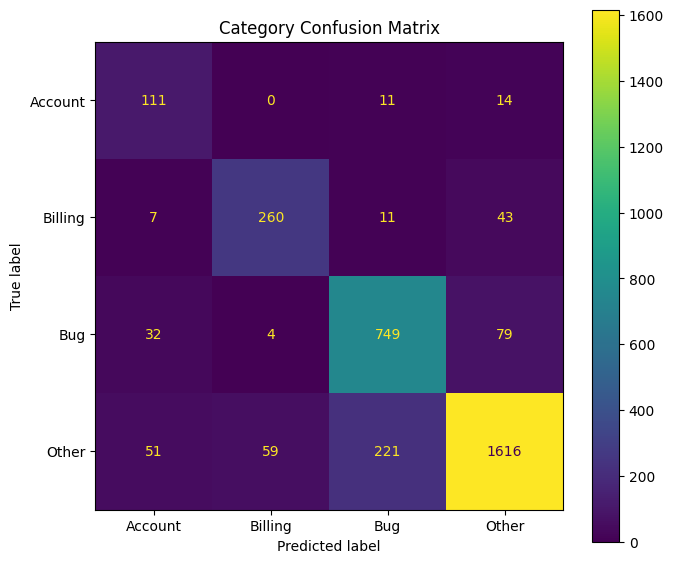

In [6]:
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    ycat_val, ycat_pred, ax=ax, values_format="d"
)
ax.set_title("Category Confusion Matrix")
plt.tight_layout()
plt.show()


## 5) Error analysis (Category)

We inspect some misclassified examples to understand failure modes.


In [7]:
val_df_cat = pd.DataFrame({
    "text": X_val,
    "y_true": ycat_val,
    "y_pred": ycat_pred
})
wrong = val_df_cat[val_df_cat["y_true"] != val_df_cat["y_pred"]].copy()
print("Misclassified (Category):", len(wrong), "/", len(val_df_cat))

# Show a few examples (random)
display(wrong.sample(min(8, len(wrong)), random_state=RANDOM_STATE).reset_index(drop=True))


Misclassified (Category): 532 / 3268


,text,y_true,y_pred
0,Challenge in Securing Medical Data | Facing di...,Other,Bug
1,Concerns About Data Security | There has been ...,Billing,Account
2,Support for Hospital Incident | An unauthorize...,Bug,Account
3,Financial Assistance | Customer Support report...,Other,Bug
4,Enhancing Security for Medical Data in Blackbo...,Other,Billing
5,Incident Report on Medical Records Data Breach...,Other,Bug
6,Detection of Unauthorized Access Attempts to H...,Other,Account
7,Critical Alert: Fault in Automated Portfolio R...,Other,Bug


## 6) Baseline #2 — Priority prediction (low/medium/high)

Same pipeline style:
- TF-IDF
- Logistic Regression


In [8]:
pri_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_features=60000,
        strip_accents="unicode"
    )),
    ("clf", LogisticRegression(
        max_iter=2500,
        class_weight="balanced",
        n_jobs=None
    ))
])

pri_clf.fit(X_train, ypri_train)
ypri_pred = pri_clf.predict(X_val)

f1_pri = f1_score(ypri_val, ypri_pred, average="macro")
print("Priority F1-macro:", round(f1_pri, 4))
print("\nClassification report (Priority):\n")
print(classification_report(ypri_val, ypri_pred))


Priority F1-macro: 0.6255

Classification report (Priority):

              precision    recall  f1-score   support

        high       0.71      0.65      0.68      1332
         low       0.52      0.62      0.57       650
      medium       0.64      0.62      0.63      1286

    accuracy                           0.64      3268
   macro avg       0.62      0.63      0.63      3268
weighted avg       0.64      0.64      0.64      3268



### Confusion Matrix — Priority

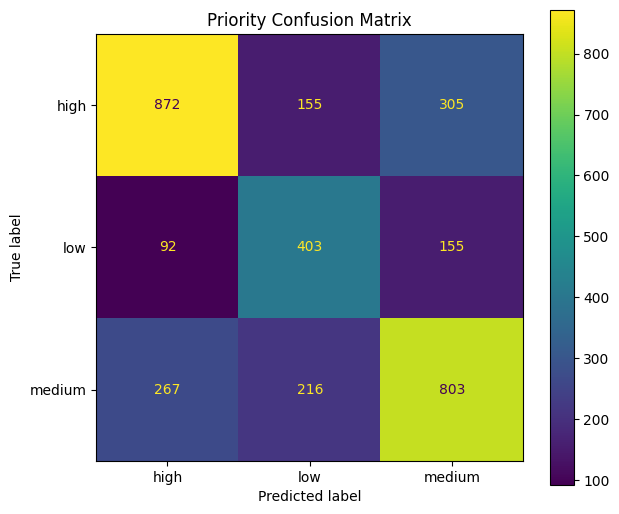

In [9]:
fig, ax = plt.subplots(figsize=(6.5, 5.5))
ConfusionMatrixDisplay.from_predictions(
    ypri_val, ypri_pred, ax=ax, values_format="d"
)
ax.set_title("Priority Confusion Matrix")
plt.tight_layout()
plt.show()


## 7) Error analysis (Priority)

Focus especially on confusion involving `high`.


In [10]:
val_df_pri = pd.DataFrame({
    "text": X_val,
    "y_true": ypri_val,
    "y_pred": ypri_pred
})
wrong_pri = val_df_pri[val_df_pri["y_true"] != val_df_pri["y_pred"]].copy()
print("Misclassified (Priority):", len(wrong_pri), "/", len(val_df_pri))

# show some high-related errors
high_related = wrong_pri[(wrong_pri["y_true"]=="high") | (wrong_pri["y_pred"]=="high")]
print("High-related errors:", len(high_related))
display(high_related.sample(min(8, len(high_related)), random_state=RANDOM_STATE).reset_index(drop=True))


Misclassified (Priority): 1190 / 3268
High-related errors: 819


,text,y_true,y_pred
0,Security Breach Alert | Possible breach in med...,low,high
1,Critical Incident Notification | Dear Customer...,medium,high
2,Customer support case regarding the documentat...,high,medium
3,Effective Security Measures for Medical Data i...,high,medium
4,Enhancing Security for Medical Data in Blackbo...,medium,high
5,Detected Incident of Unauthorized Network Acce...,high,medium
6,Enhancing Zoho CRM Growth Strategies | Could y...,high,medium
7,Revise Billing Procedure | Dear Customer Suppo...,high,low


## 8) Save models (artifacts)

These files can be used later in:
- a FastAPI API
- batch inference for monitoring
- dashboard enrichment


In [11]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

cat_path = os.path.join(MODEL_DIR, "tfidf_category_clf.joblib")
pri_path = os.path.join(MODEL_DIR, "tfidf_priority_clf.joblib")

joblib.dump(cat_clf, cat_path)
joblib.dump(pri_clf, pri_path)

print("Saved:", cat_path)
print("Saved:", pri_path)


Saved: models\tfidf_category_clf.joblib
Saved: models\tfidf_priority_clf.joblib


## 9) Portfolio-ready summary (fill with your results)

Paste your results here after running:

- Dataset: EN tickets: **{n}**
- Category model: **F1-macro = ...**
- Priority model: **F1-macro = ...**
- Observations:
  - Most confusions happen between: ...
  - `high` is sometimes confused with: ...
- Next improvement ideas (T5):
  - calibrate probabilities + thresholds for `high`
  - add metadata features (`queue`, `n_tags`, `body_len`)
  - try a transformer baseline (MiniLM / DistilBERT) for better performance
